# 18. 다양한 OCR모델 비교하기
## 노드 정리

## 순서 



## 프로젝트 시작
우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

## Step1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy
import cv2
import os

In [2]:
# load images
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
test_files = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/test/*'))
#test_kor_files = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/test/kor/*'))
test_files

['/home/aiffel-dj44/aiffel/ocr_python/test/handeng.jpeg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/layers.png',
 '/home/aiffel-dj44/aiffel/ocr_python/test/noises.jpg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/kor.jpg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/sudoku.jpg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/poster.jpg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/stars.jpg',
 '/home/aiffel-dj44/aiffel/ocr_python/test/handkor.jpg']

In [3]:
image_titles = []
images = []
for filename in test_files:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_titles.append(os.path.splitext(os.path.basename(filename))[0])
print(image_titles)

['handeng', 'layers', 'noises', 'kor', 'sudoku', 'poster', 'stars', 'handkor']


In [4]:
image_kor_titles = []
images_kor = []
for filename in test_kor_files:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_kor_titles.append(os.path.splitext(os.path.basename(filename))[0])
print(image_kor_titles)

['kor', 'handkor']


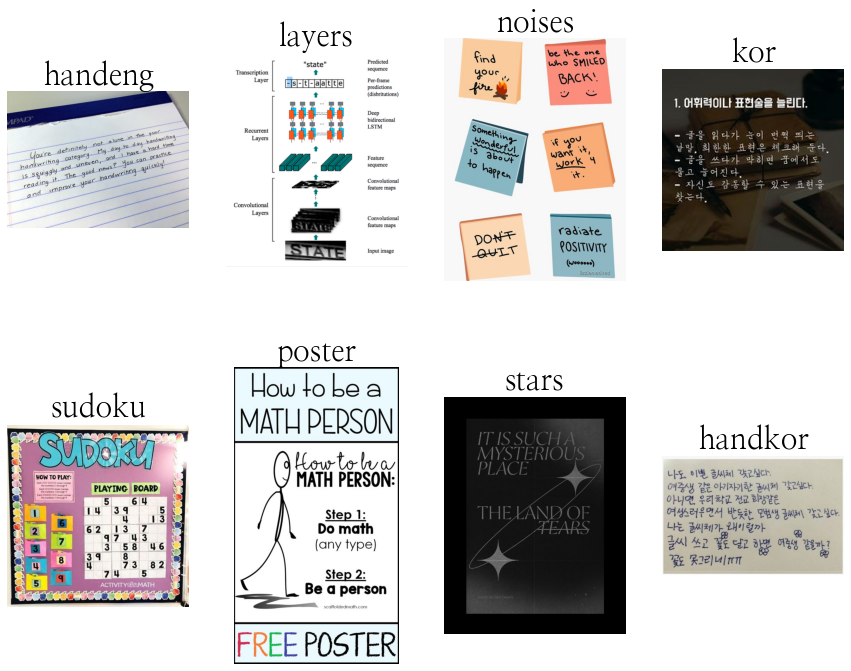

In [4]:
plt.figure(figsize=(15,12))

for i in range(len(images)):
    plt.subplot(2, 4, i+1) 
    plt.imshow(images[i])
    plt.title(image_titles[i], fontsize=30)
    plt.axis('off')
    
plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.



### 1. Google OCR API

#### 1) 구글의 파이썬 API 인터페이스 모듈 설치
```python 
$ pip install --upgrade google-api-python-client
$ pip install google-cloud-vision
```

#### 2) Google Cloud Vision API 사용
[링크](http://egloos.zum.com/mcchae/v/11342622)의 설명을 참고하여 서비스 계정 및 인증키를 생성한 후, ```my_google_api_key.json```이라는 파일명으로 저장한다. (파일은 처음에 sheet-contents-로 시작되는 이름으로 자동 저장된다.)

#### 3) 인증키 경로 등록 후 커널 재기동
터미널을 열고 아래와 같이 인증키 경로 변수를 등록한 후 커널을 종료하고 재기동한다.

```python
$ export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json
```
만약 구글 API를 계속 사용하고 싶다면 아래와 같이 환경변수에 등록해 주면 위와 같이 매번 경로 변수 설정을 하지 않아도 됩니다.

```python
$ echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc
```

#### 4) API 사용 테스트

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [29]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in zip(test_files):
    detect_text(file)
    print("----------------------------------------------")

-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 2306  3월 16 13:46 /home/aiffel-dj44/aiffel/ocr_python/my_google_api_key.json
handeng
Texts:

"MPAD
You're definitely not alone in the poor
handwriting category. My day to day handwriting
IS squiggly and uneven, and
reading it. The good news? You can practice
I have a hard time
and
improve your handwriting quickly!
"

"MPAD"

"You're"

"definitely"

"not"

"alone"

"in"

"the"

"poor"

"handwriting"

"category."

"My"

"day"

"to"

"day"

"handwriting"

"IS"

"squiggly"

"and"

"uneven,"

"and"

"reading"

"it."

"The"

"good"

"news?"

"You"

"can"

"practice"

"I"

"have"

"a"

"hard"

"time"

"and"

"improve"

"your"

"handwriting"

"quickly!"
bounds: (547,307),(649,282),(657,316),(555,340)
----------------------------------------------
layers
Texts:

"Predicted
"state"
sequence
Transcription
Layer
Per-frame
S-t-aatte
predictions
(disbritutions)
Deep
bidirectional
LSTM
Recurrent
Layers
Feature
sequence
Convolutional
feature maps
Convolutional
Laye

### 2. keras-ocr
- 주의: keras-ocr 은 tensorflow 버전 2.2.0 에서 구동된다. 2.3.X 이상 버전에서는 미리 학습된 모델에서 오류가 발생할 수 있다.

1) 텐서플로우 버전을 확인

```$ pip list | grep tensorflow```

-  만약 tensorflow 버전이 맞지 않다면 재설치를 해줍시다. 

```python
$ pip uninstall tensorflow
$ pip install tensorflow==2.2.0
```

2) keras-ocr 설치

```$ pip install keras-ocr```

터미널을 열어 아래를 입력하면 true가 출력되어야 한다. 만약 이 환경설정이 반영되어 있지 않으면 코드 구동 과정에서 OOM(Out Of Memory) 에러가 날 수 있다.


```$ echo $TF_FORCE_GPU_ALLOW_GROWTH```

만약 true가 나오지 않는다면 GPU를 사용하기 위해 아래의 명령어를 사용한다. 

```export TF_FORCE_GPU_ALLOW_GROWTH=true```

```keras_ocr.pipeline.Pipeline()``` 는 인식을 위한 파이프라인을 생성하여 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다. (검출기와 인식기를 위한 가중치 하나씩)

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel-dj44/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel-dj44/.keras-ocr/crnn_kurapan.h5


In [5]:
prediction_groups = [pipeline.recognize([file]) for file in test_files]

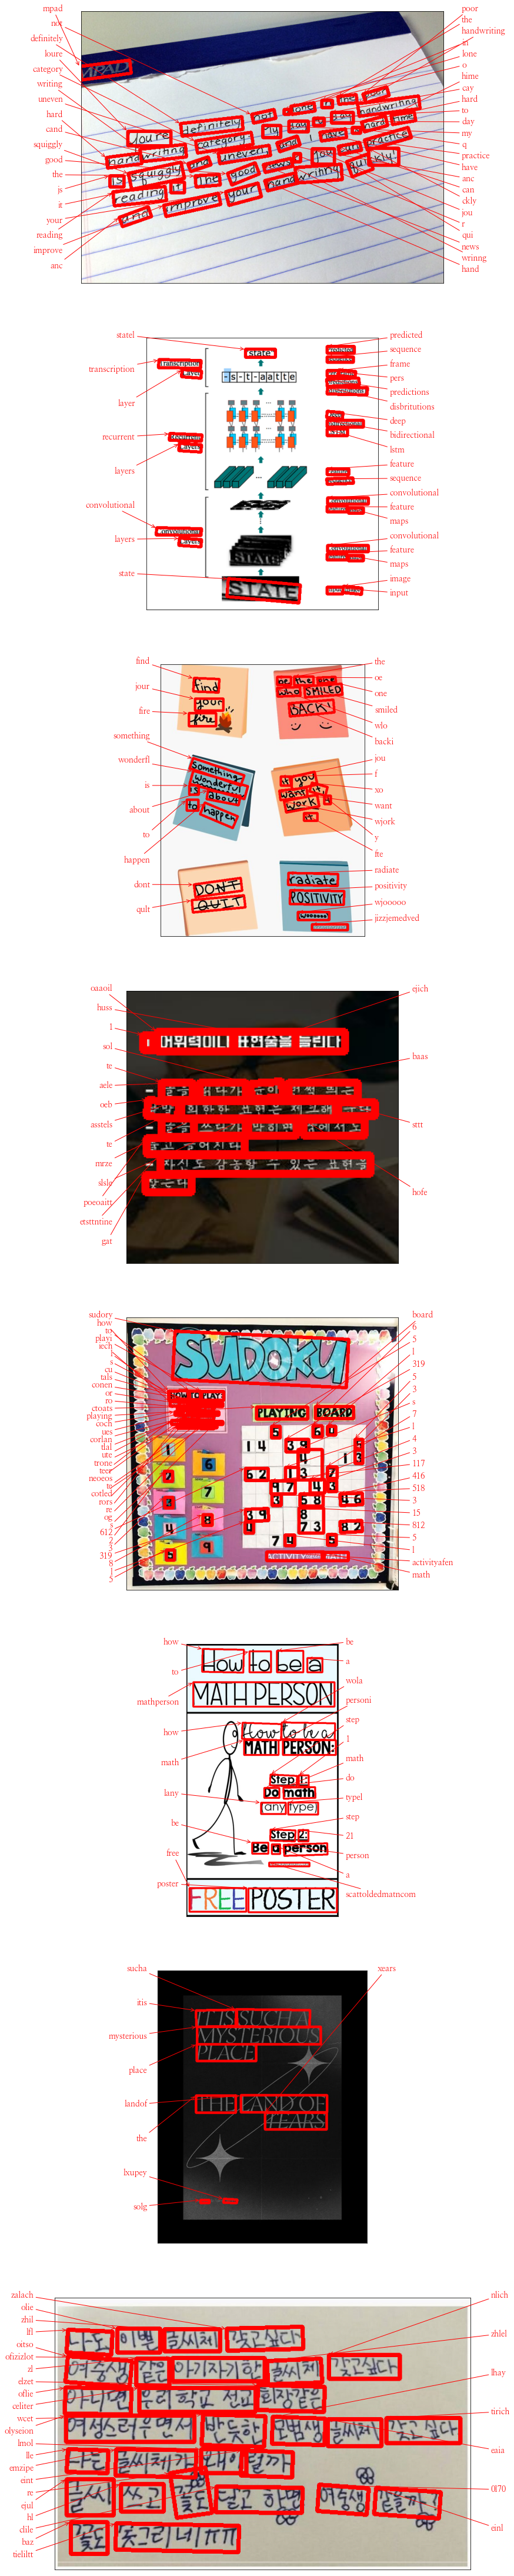

In [9]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(80, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. Tesseract
#### 1) 테서랙트 설치하기
우분투에서 실행할 경우 터미널에서 아래 코드를 사용해 테서랙트 관련 패키지들을 설치한다. 
        
```python
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

#### 2) 테서랙트 파이썬 wrapper 설치하기
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수있도록 해주는 래퍼 라이브러리(wrapper library)이다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해준다.

```python
$ pip install pytesseract
```

#### 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

- 노드의 함수 설명  

위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

기본적으로 pytesseract.image_to_data() 를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결과값의 형식을 딕셔너리(DICT) 형식으로 설정해주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다. 

#### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 image_to_string()를 사용한다.

In [6]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [32]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for file, title in zip(test_files, image_titles):
    image_path = os.path.join('./tesseract', title)
    os.makedirs(image_path, exist_ok=True)
    cropped_image_path_list = crop_word_regions(file, image_path)
    recognize_images(cropped_image_path_list)

./tesseract/handeng/0000.png

Done
./tesseract/layers/0000.png
./tesseract/layers/0001.png
./tesseract/layers/0002.png
./tesseract/layers/0003.png
./tesseract/layers/0004.png
./tesseract/layers/0005.png
./tesseract/layers/0006.png
./tesseract/layers/0007.png
./tesseract/layers/0008.png
./tesseract/layers/0009.png
./tesseract/layers/0010.png
./tesseract/layers/0011.png
./tesseract/layers/0012.png
./tesseract/layers/0013.png
./tesseract/layers/0014.png
./tesseract/layers/0015.png
./tesseract/layers/0016.png
./tesseract/layers/0017.png
./tesseract/layers/0018.png
./tesseract/layers/0019.png
./tesseract/layers/0020.png
./tesseract/layers/0021.png
./tesseract/layers/0022.png
./tesseract/layers/0023.png
./tesseract/layers/0024.png
./tesseract/layers/0025.png
./tesseract/layers/0026.png
./tesseract/layers/0027.png
./tesseract/layers/0028.png
./tesseract/layers/0029.png
./tesseract/layers/0030.png
./tesseract/layers/0031.png
./tesseract/layers/0032.png
Transcription

Layer

Kecurrent

Conv

- os.makedirs(image_path, exist_ok=True)    
폴더 만들기 함수. ```exist_ok=True```를 지정하면 폴더가 존재하지 않으면 생성하고 존재하면 아무 것도 하지 않는다. (참고: https://ponyozzang.tistory.com/437)

한글 이미지 파일도 테서렉트로 단어 인식을 시도하였다. 

테서랙트의 언어팩을 설치하고 ```lang='kor'``` 로 바꾼다.

```$ sudo apt install tesseract-ocr-kor```

In [23]:
def crop_word_regions_kor(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list_kor = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list_kor.append(output_img_path)
            index += 1
    return cropped_image_path_list_kor

In [24]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [48]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.

for file, title in zip(test_kor_files, image_kor_titles):
    image_path = os.path.join('./tesseract', title)
    os.makedirs(image_path, exist_ok=True)
    cropped_image_path_list_kor = crop_word_regions_kor(file, image_path)
    recognize_images_kor(cropped_image_path_list_kor)

./tesseract/kor/0000.png
./tesseract/kor/0001.png
./tesseract/kor/0002.png
./tesseract/kor/0003.png
./tesseract/kor/0004.png
./tesseract/kor/0005.png
./tesseract/kor/0006.png
./tesseract/kor/0007.png
./tesseract/kor/0008.png
./tesseract/kor/0009.png
./tesseract/kor/0010.png
./tesseract/kor/0011.png
』

1;


고

|

건

주)

0

그

을

즐리 |

- 미

Done
./tesseract/handkor/0000.png
./tesseract/handkor/0001.png
./tesseract/handkor/0002.png
./tesseract/handkor/0003.png
./tesseract/handkor/0004.png
./tesseract/handkor/0005.png
./tesseract/handkor/0006.png
./tesseract/handkor/0007.png
./tesseract/handkor/0008.png
./tesseract/handkor/0009.png
./tesseract/handkor/0010.png
./tesseract/handkor/0011.png
./tesseract/handkor/0012.png
./tesseract/handkor/0013.png
./tesseract/handkor/0014.png
./tesseract/handkor/0015.png
./tesseract/handkor/0016.png
./tesseract/handkor/0017.png
./tesseract/handkor/0018.png
./tesseract/handkor/0019.png
./tesseract/handkor/0020.png
./tesseract/handkor/0021.png
./te

## Step3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

8개의 이미지 중 4개만 가져와 결과를 정리해 보았다. 첫번째는 영어 손글씨이고, 두번째는 평범한 이미지, 세번째는 글씨 위에 밑줄이 쳐지는 등 노이즈가 있는 이미지, 마지막은 한글 이미지이다.

In [92]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
result1 = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/result/result1/*'))

images = []
for filename in result1:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)

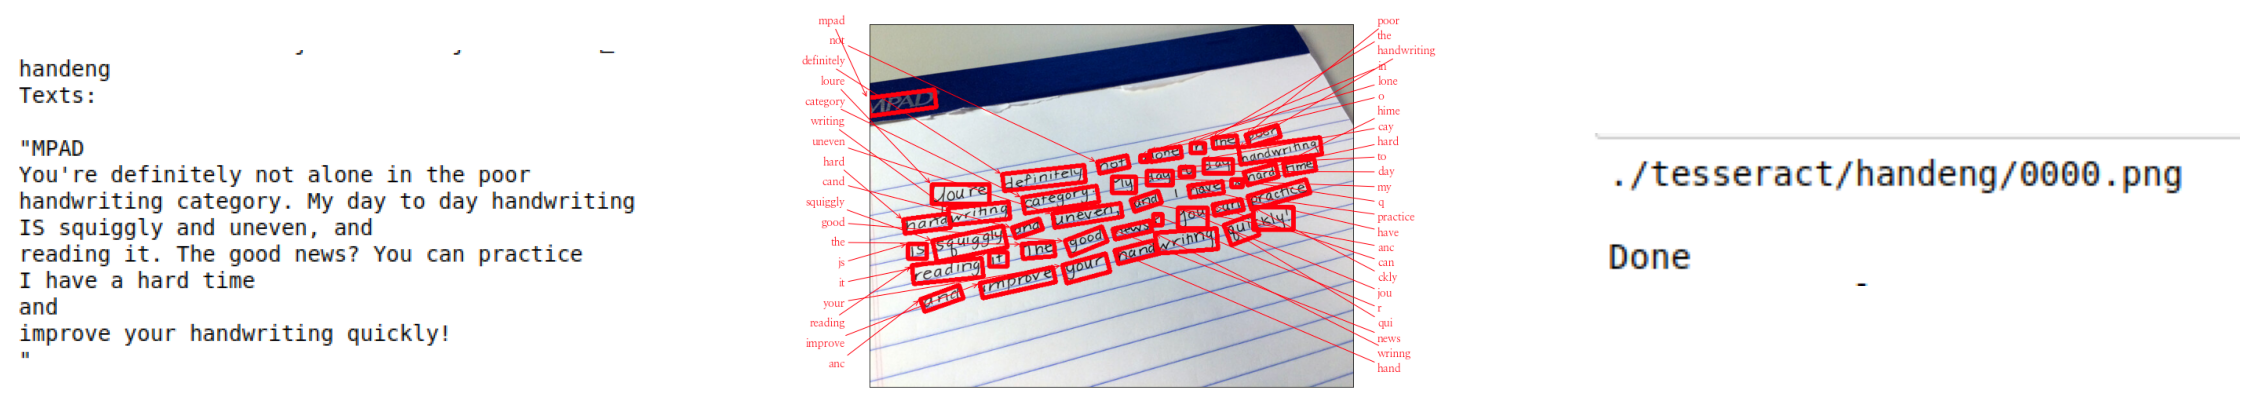

In [93]:
plt.figure(figsize=(40,40))

for i in range(len(images)):
    plt.subplot(1, 3, i+1) 
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()


영어 손글씨의 경우, Google OCR API와 keras-ocr은 대체로 잘 인식하고 있다. 자세히 살펴보자면 Google OCR API의 경우는 대부분의 글씨를 인식하였으나 문장의 순서가 섞여있다. keras-ocr은 한 단어를 잘라서 인식하거나 스펠링을 잘못 인식하는 경우가 있었다. 반면 한 글자도 인식하지 못하였다.

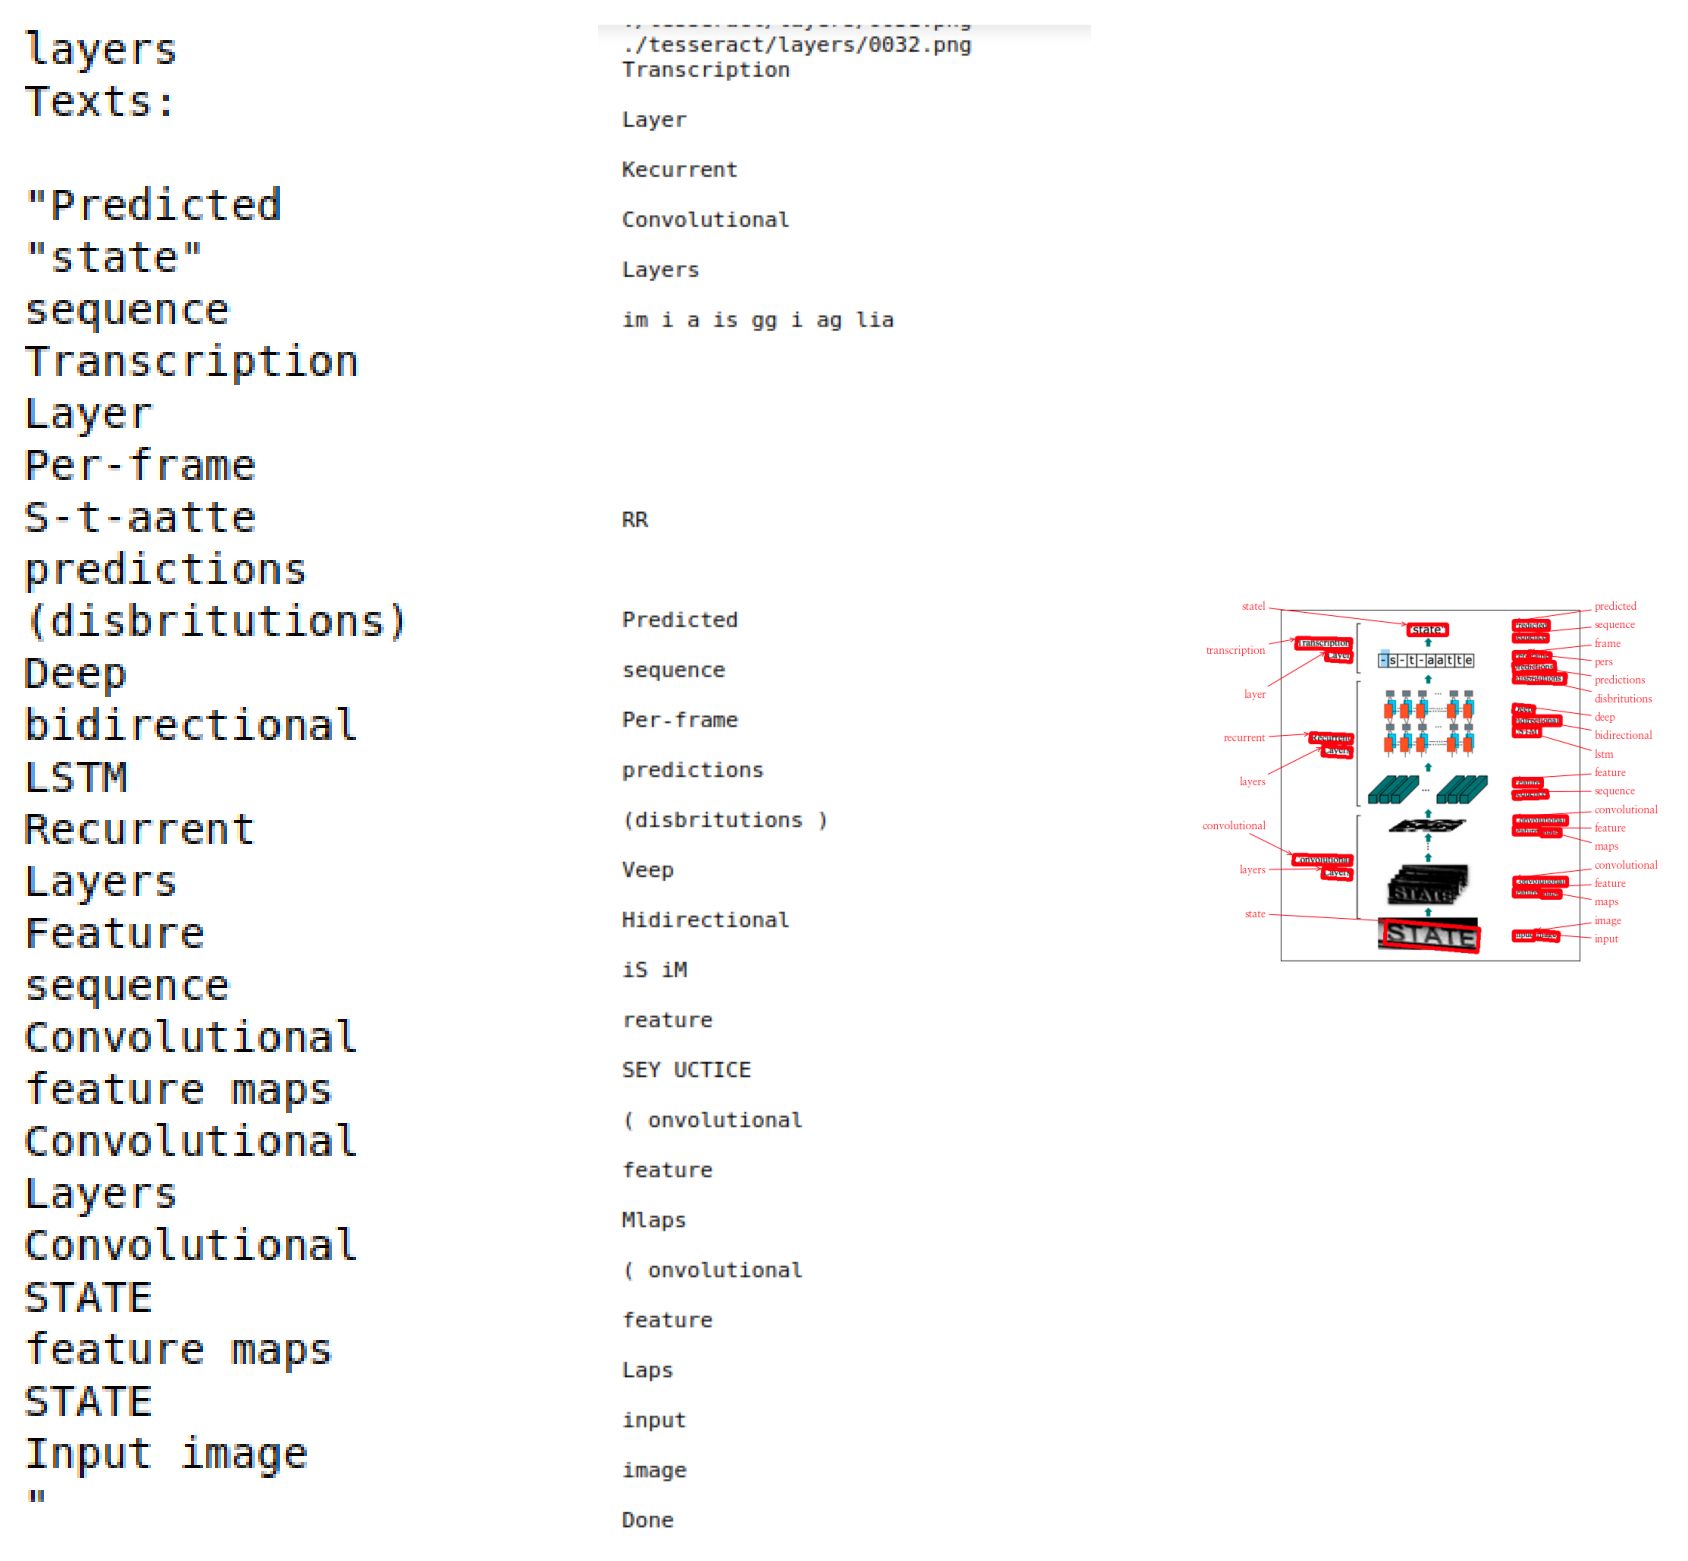

In [94]:
result2 = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/result/result2/*'))

images = []
for filename in result2:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        
plt.figure(figsize=(30,30))

for i in range(len(images)):
    plt.subplot(1, 3, i+1) 
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()


이미지는 순서대로 keras-ocr, Tesseract, Google OCR API이다. 컴퓨터로 작성한 글씨의 이미지는 Google OCR API가 가장 잘 인식하였다. keras-ocr의 경우는 인식하지 못한 단어가 몇 개 있었고, Tesseract는 인식하지 못한 단어와 잘못 인식한 단어가 많았다. 

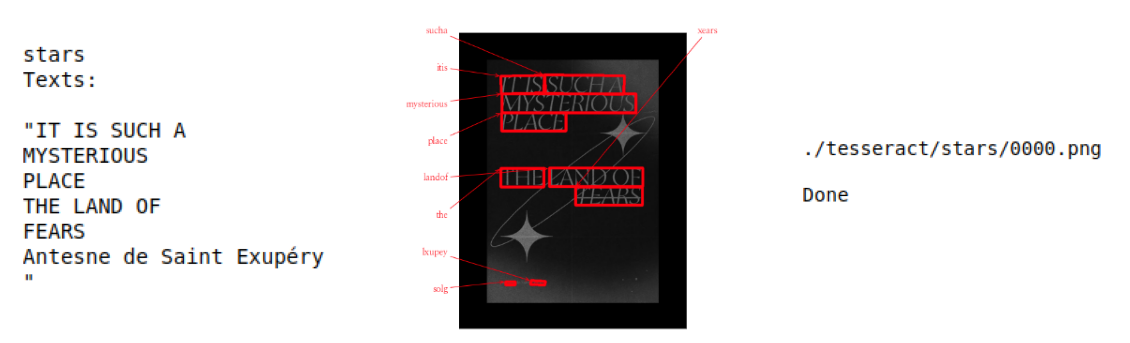

In [97]:
result3 = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/result/result3/*'))

images = []
for filename in result3:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        
plt.figure(figsize=(20,20))

for i in range(len(images)):
    plt.subplot(1, 3, i+1) 
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()


이미지는 순서대로 Google OCR API, keras-ocr, Tesseract이다. 어둡고 글자가 서로 붙어 있어 있으며, 글씨 위에 밑줄이 그어져 있는 등 노이즈가 섞인 이미지의 경우 Google OCR API는 글씨를 정확하게 인식하였다. 작은 글씨까지도 인식하였다. keras-ocr의 경우는 글자가 붙어 있으면 하나의 단어로 인식했고 밑줄이 그어진 단어는 다른 단어로 인식했다. 작은 글씨 역시 정확히 인식하지 못하는 것을 볼 수 있다. Tesseract는 하나의 단어도 인식하지 못하였다.

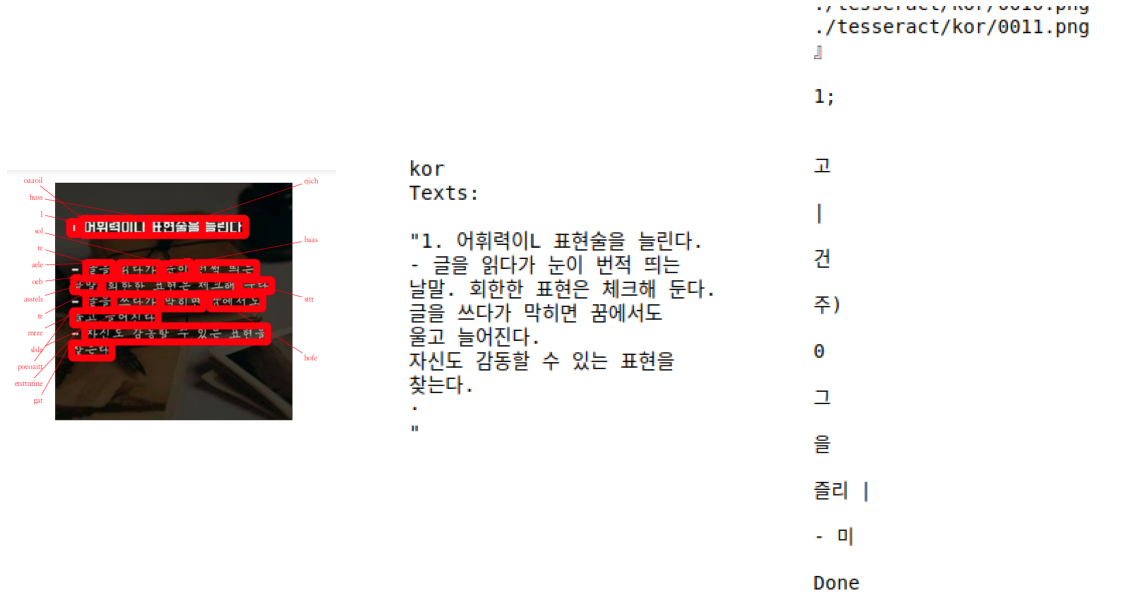

In [90]:
result4 = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/result/result4/*'))

images = []
for filename in result4:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        
plt.figure(figsize=(20,20))

for i in range(len(images)):
    plt.subplot(1, 3, i+1) 
    plt.imshow(images[i])
    plt.axis('off')
    
plt.show()


이미지는 순서대로 keras-ocr, Google OCR API, Tesseract이다. 한글이미지의 경우 keras-ocr은 제대로 인식하지 못함을 알 수 있다. Google API는 정확히 글자와 문장의 구조를 인식하였다. Tesseract는 제대로 인식하지 못하고 있다.

## Step4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가기준을 제시합니다.
그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

### Tesseract 추가 실험
Tesseract의 결과가 너무 좋지 않아서 어떻게 하면 좋은 결과를 얻을 수 있는지 검색해 보았다. [이 블로그](https://junyoung-jamong.github.io/computer/vision,/ocr/2019/01/30/Python%EC%97%90%EC%84%9C-Tesseract%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%B4-OCR-%EC%88%98%ED%96%89%ED%95%98%EA%B8%B0.html)에 의하면 텍스트 추출 정확도는 이미지에 따라서 다를 수 있다고 한다. 이미지에 노이즈가 많거나 이미지의 사전 처리가 되지 않으면 성능이 크게 떨어질 수 있으므로 이미지의 특정 텍스트 부분만 잘라 텍스트를 추출함으로써 성능을 높일 수 있다. 따라서 텍스트만 존재하는 이미지로 다시 시도해 보았다.

In [37]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
word_files = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/tesseract/*'))
print(word_files)

['/home/aiffel-dj44/aiffel/ocr_python/tesseract/words.jpeg', '/home/aiffel-dj44/aiffel/ocr_python/tesseract/kors.png', '/home/aiffel-dj44/aiffel/ocr_python/tesseract/kr.png']


In [38]:
image_titles = []
images = []
for filename in word_files:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_titles.append(os.path.splitext(os.path.basename(filename))[0])
print(image_titles)

['words', 'kors', 'kr']


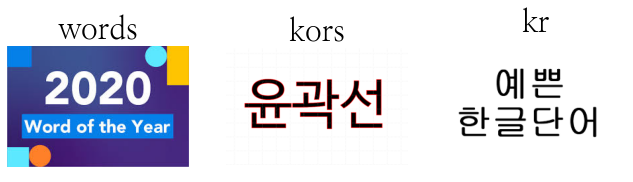

In [39]:
plt.figure(figsize=(15,12))

for i in range(len(images)):
    plt.subplot(2, 4, i+1) 
    plt.imshow(images[i])
    plt.title(image_titles[i], fontsize=30)
    plt.axis('off')
    
plt.show()


In [30]:
img_file_path = ROOT_PATH + '/ocr_python/tesseract/words.jpeg'

cropped_image_path_list = crop_word_regions(img_file_path, ROOT_PATH)
recognize_images(cropped_image_path_list)

/home/aiffel-dj44/aiffel/0000.png
/home/aiffel-dj44/aiffel/0001.png
/home/aiffel-dj44/aiffel/0002.png
/home/aiffel-dj44/aiffel/0003.png
/home/aiffel-dj44/aiffel/0004.png
/home/aiffel-dj44/aiffel/0005.png
2020

wd

Word

ot

the

Year

Done


In [32]:
img_file_path = ROOT_PATH + '/ocr_python/tesseract/kors.png'

cropped_image_path_list_kor = crop_word_regions_kor(img_file_path, ROOT_PATH)
recognize_images_kor(cropped_image_path_list_kor)

/home/aiffel-dj44/aiffel/0000.png
/home/aiffel-dj44/aiffel/0001.png
/home/aiffel-dj44/aiffel/0002.png
유

과

선

Done


In [40]:
img_file_path = ROOT_PATH + '/ocr_python/tesseract/kr.png'

cropped_image_path_list_kor = crop_word_regions_kor(img_file_path, ROOT_PATH)
recognize_images_kor(cropped_image_path_list_kor)

/home/aiffel-dj44/aiffel/0000.png
/home/aiffel-dj44/aiffel/0001.png
/home/aiffel-dj44/aiffel/0002.png
/home/aiffel-dj44/aiffel/0003.png
/home/aiffel-dj44/aiffel/0004.png
ㅁㅁ

0

다

베

안

Done


Tesseract의 정확도를 개선하는 다른 방법으로는 그레이 스케일로 변환하거나 블러처리를 하는 방법이 있다고 하여 시도해보았다. 

In [49]:
img_file_path = ROOT_PATH + '/ocr_python/tesseract/poster.jpg'

import cv2

image = cv2.imread('img_file_path')
gray = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cropped_image_path_list = crop_word_regions(img_file_path, ROOT_PATH)
recognize_images(cropped_image_path_list)

/home/aiffel-dj44/aiffel/0000.png
/home/aiffel-dj44/aiffel/0001.png
/home/aiffel-dj44/aiffel/0002.png
/home/aiffel-dj44/aiffel/0003.png
/home/aiffel-dj44/aiffel/0004.png
/home/aiffel-dj44/aiffel/0005.png
/home/aiffel-dj44/aiffel/0006.png
/home/aiffel-dj44/aiffel/0007.png
/home/aiffel-dj44/aiffel/0008.png
/home/aiffel-dj44/aiffel/0009.png
/home/aiffel-dj44/aiffel/0010.png
/home/aiffel-dj44/aiffel/0011.png
/home/aiffel-dj44/aiffel/0012.png
/home/aiffel-dj44/aiffel/0013.png
/home/aiffel-dj44/aiffel/0014.png
/home/aiffel-dj44/aiffel/0015.png
/home/aiffel-dj44/aiffel/0016.png
/home/aiffel-dj44/aiffel/0017.png
/home/aiffel-dj44/aiffel/0018.png
/home/aiffel-dj44/aiffel/0019.png
/home/aiffel-dj44/aiffel/0020.png
/home/aiffel-dj44/aiffel/0021.png
/home/aiffel-dj44/aiffel/0022.png
/home/aiffel-dj44/aiffel/0023.png
/home/aiffel-dj44/aiffel/0024.png
/home/aiffel-dj44/aiffel/0025.png
/home/aiffel-dj44/aiffel/0026.png
Hoy

lo

Lo

Zs

MATL

DLERSON

your

Ts

p

OS

AIF


step

|:

DO


평가문항	상세기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?

목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?

평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.